In [1]:
import pandas as pd
import numpy as np
import modeltest as deep
import experiment as exp
import myutil as util
import tensorflow as tf
from itertools import product

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
import importlib
importlib.reload(deep)
importlib.reload(exp)

<module 'experiment' from 'c:\\Users\\kyeongtaek\\generative_model\\foresttype\\experiment.py'>

In [2]:
#파일 읽기
filepath_german_csv = 'covtype.csv'
d_german_df = pd.read_csv(filepath_german_csv)

#numpy 변환
d_german_np = np.array(d_german_df)

# sample 수, 특징 수 등 계산
n_row = d_german_np.shape[0]
n_features = d_german_np.shape[1]-1

# 입력과 출력 데이터 분리
x = d_german_np[:, :n_features]
y = d_german_np[:, n_features]-1

#정규화
x_norm = (x - np.min(x,0))/ (np.max(x,0) - np.min(x,0))
y_norm = (y - np.min(y,0))/ (np.max(y,0) - np.min(y,0))

In [3]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [3]:
import tensorflow_addons as tfa

c:\Users\kyeongtaek\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Triplet Loss

Epoch 1/200
7263/7263 - 52s - loss: 0.1286 - val_loss: 0.1137 - 52s/epoch - 7ms/step
Epoch 2/200
7263/7263 - 51s - loss: 0.1254 - val_loss: 0.1308 - 51s/epoch - 7ms/step
Epoch 3/200
7263/7263 - 51s - loss: 0.1284 - val_loss: 0.1214 - 51s/epoch - 7ms/step
Epoch 4/200
7263/7263 - 50s - loss: 0.1230 - val_loss: 0.1153 - 50s/epoch - 7ms/step
Epoch 5/200
7263/7263 - 51s - loss: 0.1165 - val_loss: 0.1116 - 51s/epoch - 7ms/step
Epoch 6/200
7263/7263 - 50s - loss: 0.1107 - val_loss: 0.1018 - 50s/epoch - 7ms/step
Epoch 7/200
7263/7263 - 50s - loss: 0.1055 - val_loss: 0.1005 - 50s/epoch - 7ms/step
Epoch 8/200
7263/7263 - 51s - loss: 0.1008 - val_loss: 0.0948 - 51s/epoch - 7ms/step
Epoch 9/200
7263/7263 - 51s - loss: 0.0965 - val_loss: 0.0920 - 51s/epoch - 7ms/step
Epoch 10/200
7263/7263 - 51s - loss: 0.0933 - val_loss: 0.0895 - 51s/epoch - 7ms/step
Epoch 11/200
7263/7263 - 50s - loss: 0.0895 - val_loss: 0.0856 - 50s/epoch - 7ms/step
Epoch 12/200
7263/7263 - 51s - loss: 0.0869 - val_loss: 0.0800 

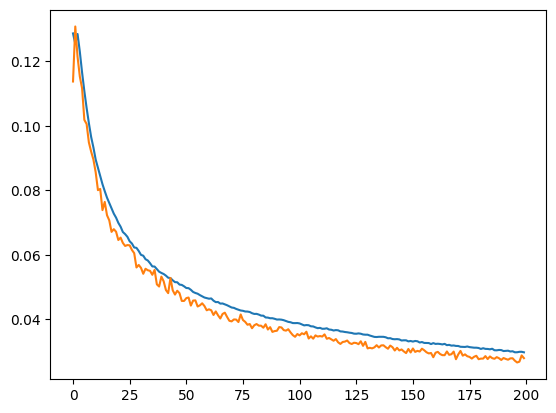

In [10]:
# 10fold validation 수행여부
bTenFoldValidation = False
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.0, val_ratio=0.2)

    # 모델 불러오기 & 컴파일
    g = deep.encoder(x.shape[1:])
        
    g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

    hist = g.fit(x_train, y_train, epochs=200, batch_size = 64, validation_data=(x_val, y_val), verbose=2)
    # 결과 출력

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기

    N = 10
    total = 0
    nClass = 2
    cm = np.zeros([N, nClass, nClass])
    for i in range(N):
        # Train/Test 데이터 분할
        [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x_norm, y, fold=N, idx=i)

        # 모델 불러오기 & 컴파일
        g = deep.encoder(x.shape[1:])
        
        g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

        # 학습
        hist = g.fit(x_train, y_train, epochs=2000, batch_size = 256, validation_data=(x_test, y_test))
        
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['accuracy'])
    #plt.plot(result.val_acc)
        plt.show()


Triplet 전이학습

In [18]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.0, val_ratio=0.2)

    # 모델 불러오기 & 컴파일
    g = deep.encoder(x.shape[1:])
        
    g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

    hist = g.fit(x_train, y_train, epochs=500, batch_size = 16, validation_data=(x_val, y_val))
    
    g.trainable=False
    m = deep.final_model(x.shape[1:], g, (1296,))
    
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=1000, batch_size_per_class=16)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_val)), -1) == y_val) / y_val.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기
    
    # General settings
    base_settings = {'epochs': 300}
    # Grid search
    grid = {
        'batch_size': [32, 64, 128],
        'learning_rate': [0.001, 0.0001]
    }

    N = 10
    total = 0
    nClass = 2
    cm = np.zeros([N, nClass, nClass])
    for i in range(N):
        # Train/Test 데이터 분할
        [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x_norm, y, fold=N, idx=i)

        # 모델 불러오기 & 컴파일
        g = deep.encoder(x.shape[1:])
        
        g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

        # 학습
        hist = g.fit(x_train, y_train, epochs=200, batch_size = 64)
        g.trainable=False
        m = deep.final_model(x.shape[1:], g, g.output_shape[1:])
        
        m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        
        # 학습시 사용하는 옵션
        train_options = exp.TrainParams(m, epochs=3000, batch_size_per_class=128)
        
        result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)
        
        # 테스트
        o = np.argmax(np.squeeze(result.model.predict(x_test)), -1)
        test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
        #for j in range(y_test.shape[0]):
            #cm[i, int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산

        # 결과 출력
        print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
        plt.plot(result.train_acc)
        plt.plot(result.val_acc)
        plt.show()
        total = total + test_acc_tmp

ave = total/10
print(f'average accuracy : {ave}')

Epoch 1/200
8171/8171 [==============================] - 62s 8ms/step - loss: 0.1507
Epoch 2/200
8171/8171 [==============================] - 63s 8ms/step - loss: 0.1432
Epoch 3/200
8171/8171 [==============================] - 61s 7ms/step - loss: 0.1356
Epoch 4/200
8171/8171 [==============================] - 61s 8ms/step - loss: 0.1274
Epoch 5/200
8171/8171 [==============================] - 62s 8ms/step - loss: 0.1193
Epoch 6/200
8171/8171 [==============================] - 61s 8ms/step - loss: 0.1123
Epoch 7/200
8171/8171 [==============================] - 61s 8ms/step - loss: 0.1060
Epoch 8/200
8171/8171 [==============================] - 61s 7ms/step - loss: 0.1019
Epoch 9/200
8171/8171 [==============================] - 62s 8ms/step - loss: 0.0974
Epoch 10/200
8171/8171 [==============================] - 61s 8ms/step - loss: 0.0940
Epoch 11/200
8171/8171 [==============================] - 60s 7ms/step - loss: 0.0906
Epoch 12/200
8171/8171 [==============================] - 60s 7

KeyboardInterrupt: 

Gird Search

1816/1816 [==============================] - 4s 2ms/step
0/10	 test_acc:0.939846130014974


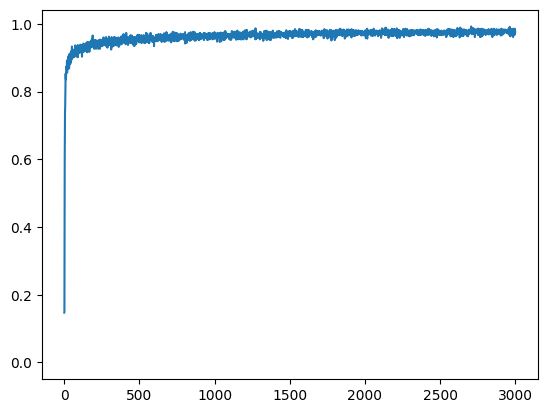

1816/1816 [==============================] - 4s 2ms/step
1/10	 test_acc:0.9383831603586857


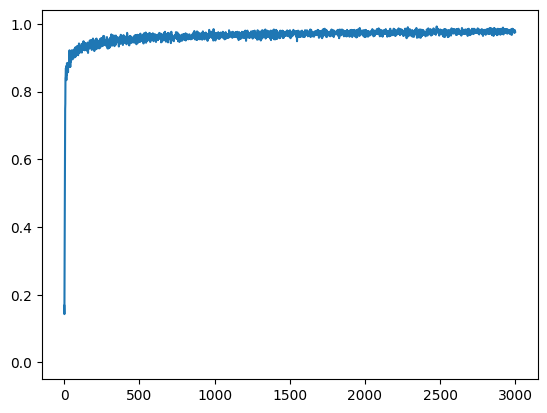

1816/1816 [==============================] - 4s 2ms/step
2/10	 test_acc:0.9404313178774892


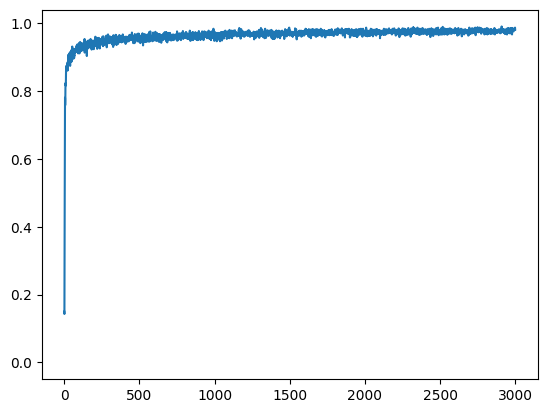

1816/1816 [==============================] - 4s 2ms/step
3/10	 test_acc:0.9429958176279238


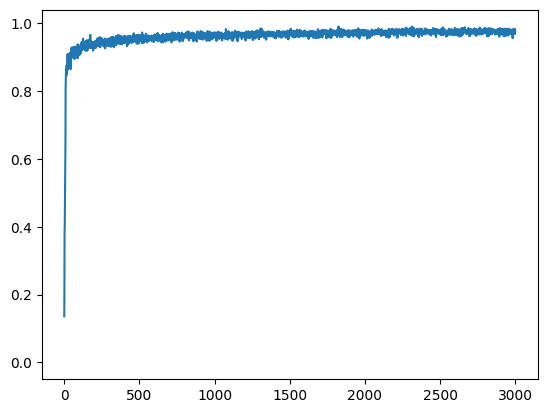

1816/1816 [==============================] - 4s 2ms/step
4/10	 test_acc:0.9420664016109878


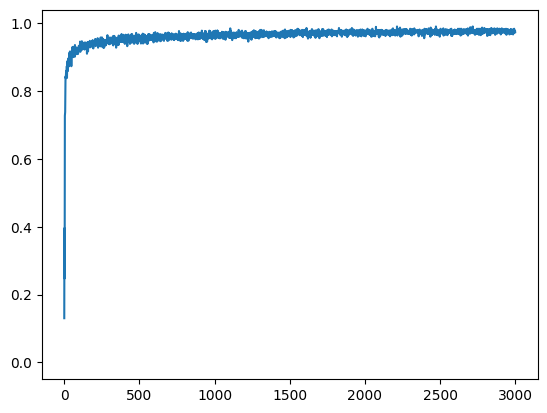

1816/1816 [==============================] - 4s 2ms/step
5/10	 test_acc:0.9379700865733809


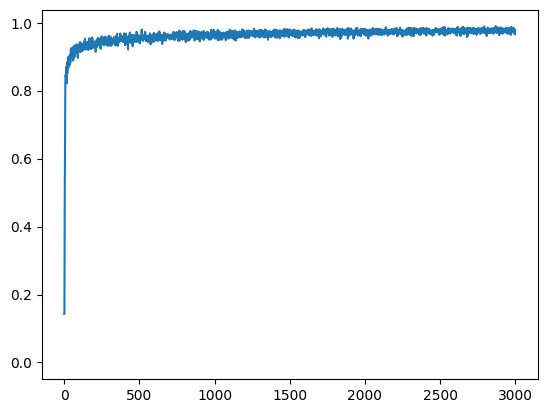

1816/1816 [==============================] - 4s 2ms/step
6/10	 test_acc:0.9400526669076263


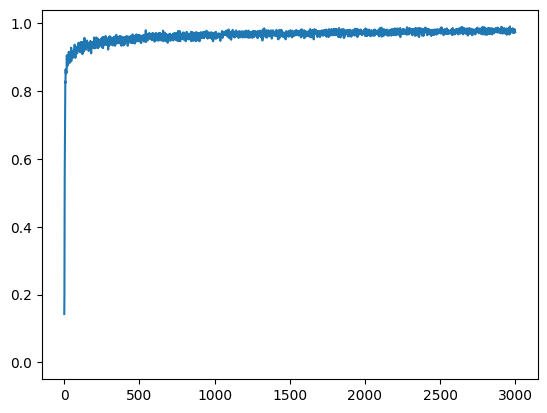

1816/1816 [==============================] - 4s 2ms/step
7/10	 test_acc:0.943546582674997


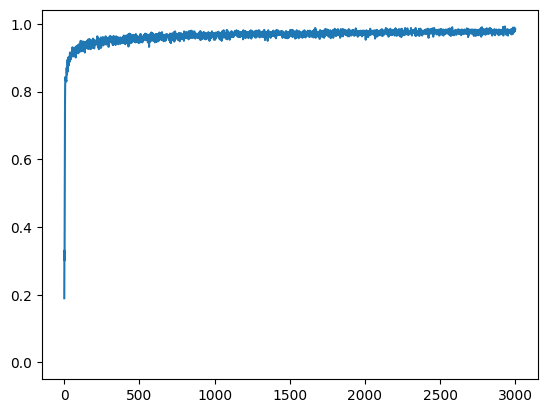

1816/1816 [==============================] - 4s 2ms/step
8/10	 test_acc:0.941257465448099


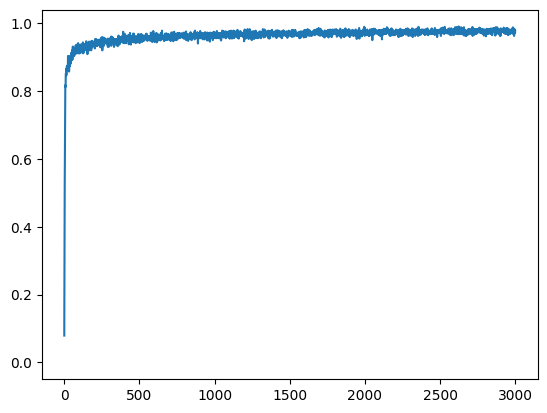

1816/1816 [==============================] - 4s 2ms/step
9/10	 test_acc:0.9386929656976644


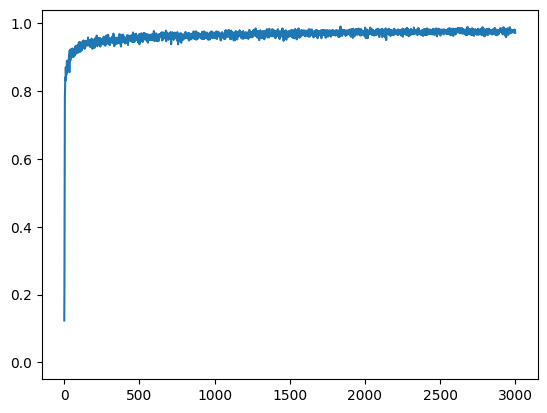

average accuracy : 0.9405242594791827
average loss : [1.98047138 1.86908324 1.7428424  ... 0.07041175 0.06055308 0.06593989]
1816/1816 [==============================] - 4s 2ms/step
0/10	 test_acc:0.9438563880139756


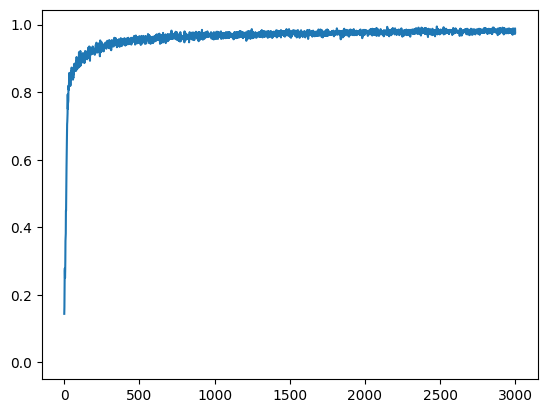

1816/1816 [==============================] - 4s 2ms/step
1/10	 test_acc:0.9469028071805993


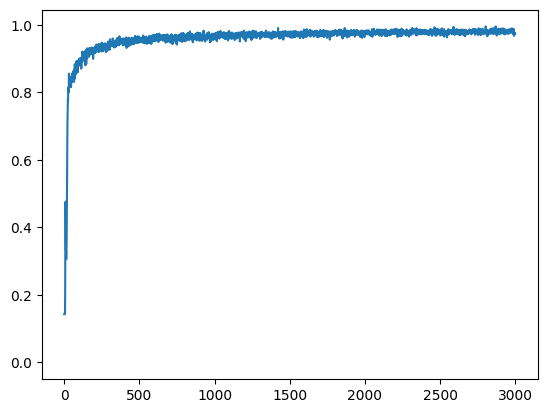

1816/1816 [==============================] - 4s 2ms/step
2/10	 test_acc:0.9420836130187088


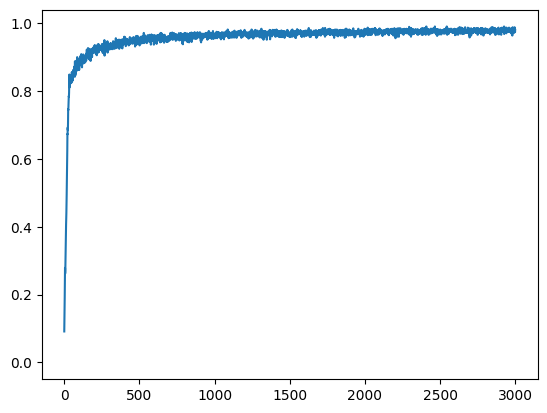

1816/1816 [==============================] - 4s 2ms/step
3/10	 test_acc:0.938486428805012


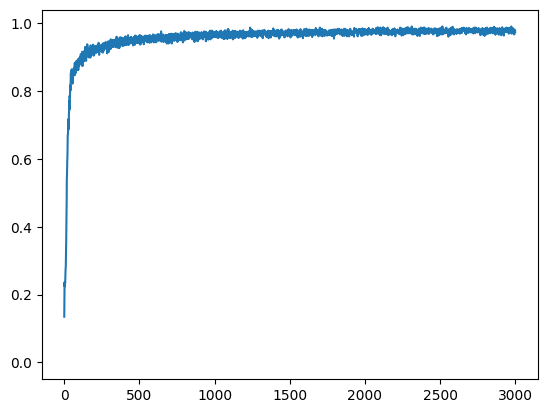

1816/1816 [==============================] - 4s 2ms/step
4/10	 test_acc:0.9464725219875734


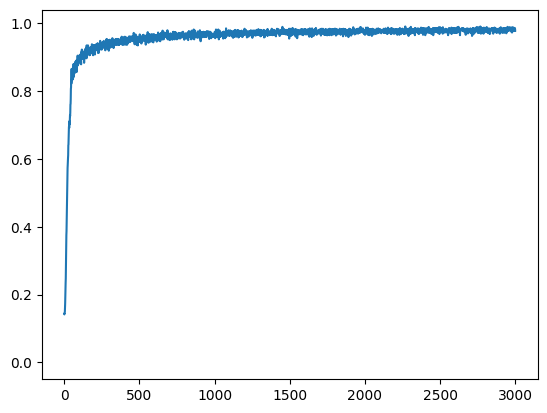

1816/1816 [==============================] - 4s 2ms/step
5/10	 test_acc:0.9451128207776114


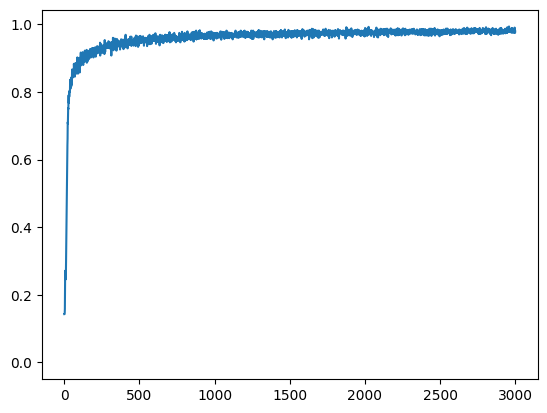

1816/1816 [==============================] - 4s 2ms/step
6/10	 test_acc:0.9467134816956679


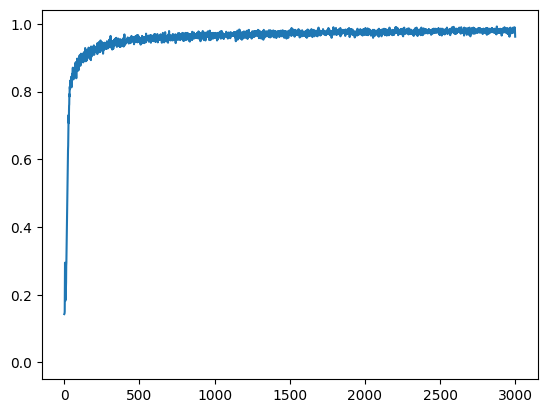

1816/1816 [==============================] - 4s 2ms/step
7/10	 test_acc:0.9470921326655307


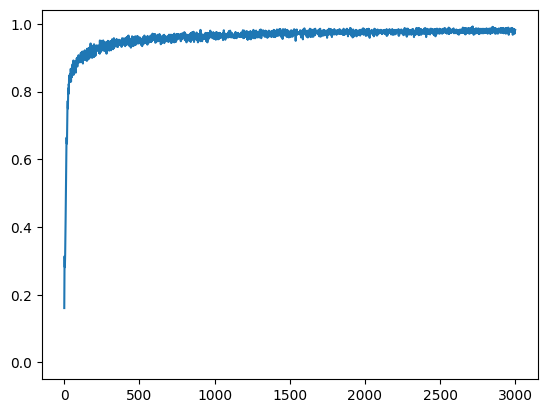

1816/1816 [==============================] - 4s 2ms/step
8/10	 test_acc:0.9441317705375123


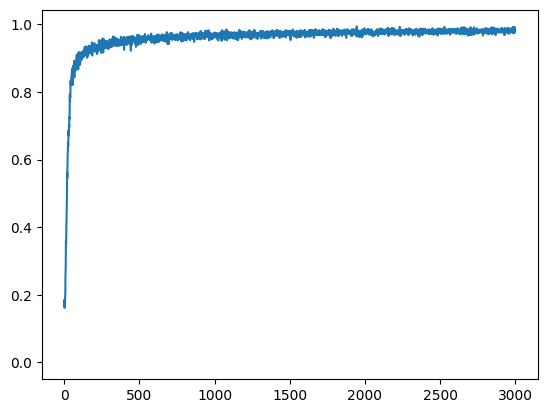

1816/1816 [==============================] - 4s 2ms/step
9/10	 test_acc:0.9436326397136022


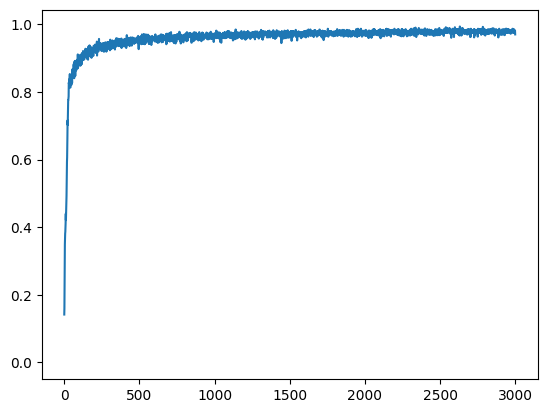

average accuracy : 0.9444484604395793
average loss : [1.98149514 1.9518669  1.92750428 ... 0.05125983 0.05602862 0.06323877]
1816/1816 [==============================] - 4s 2ms/step
0/10	 test_acc:0.9509819108104852


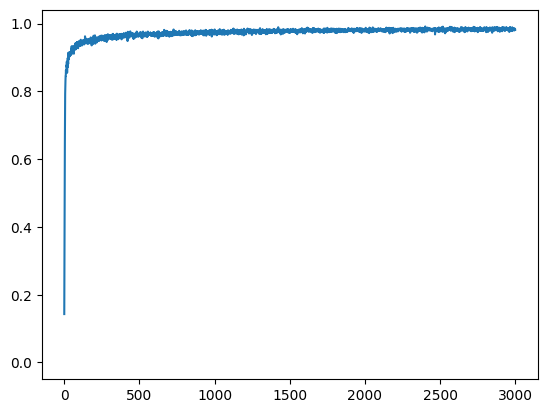

1816/1816 [==============================] - 4s 2ms/step
1/10	 test_acc:0.9473330923736253


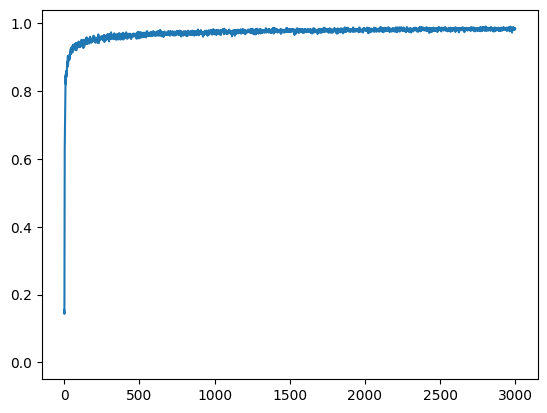

1816/1816 [==============================] - 4s 2ms/step
2/10	 test_acc:0.9489853875148448


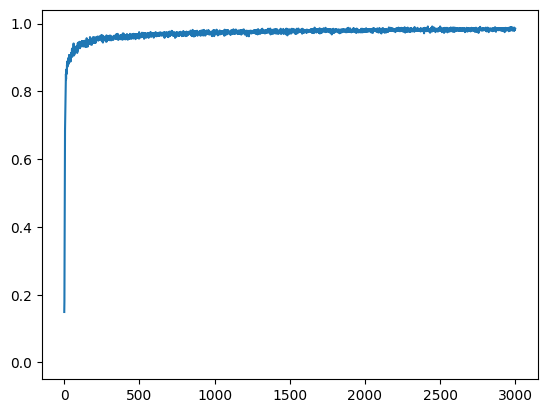

1816/1816 [==============================] - 4s 2ms/step
3/10	 test_acc:0.9460078139791054


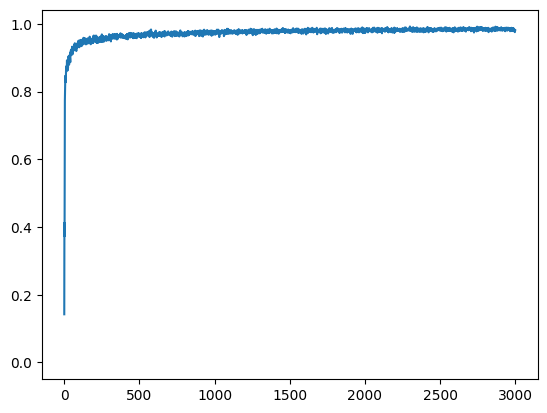

1816/1816 [==============================] - 4s 2ms/step
4/10	 test_acc:0.9461799280563157


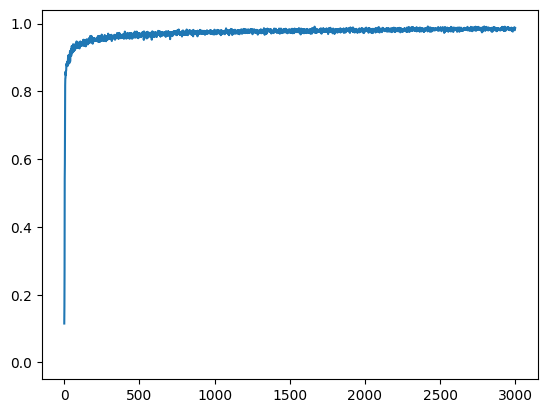

1816/1816 [==============================] - 4s 2ms/step
5/10	 test_acc:0.9482108741673981


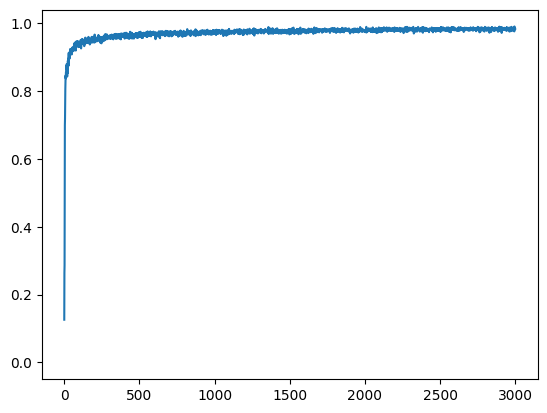

1816/1816 [==============================] - 4s 2ms/step
6/10	 test_acc:0.9483313540214454


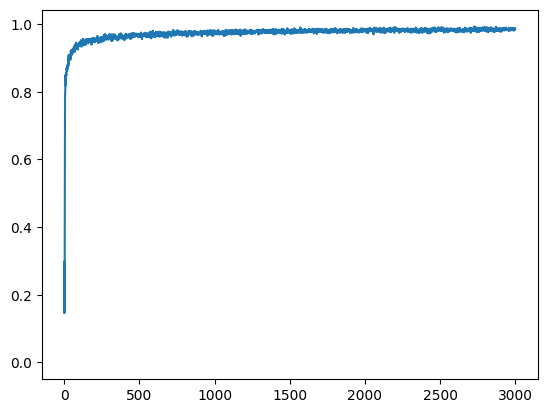

1816/1816 [==============================] - 4s 2ms/step
7/10	 test_acc:0.9472986695581832


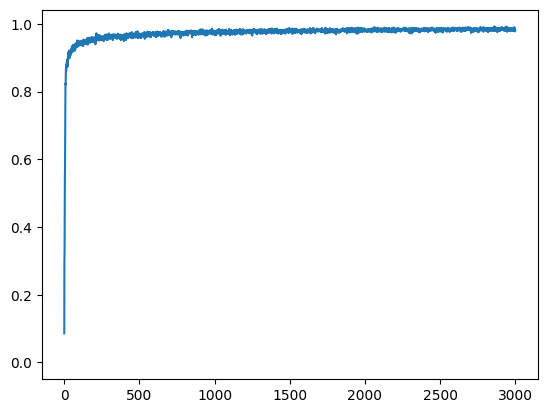

1816/1816 [==============================] - 4s 2ms/step
8/10	 test_acc:0.9478666460129774


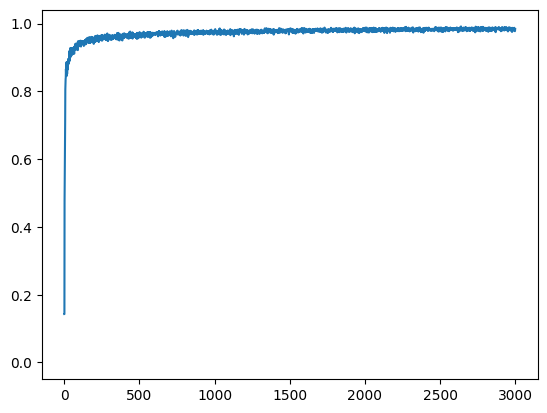

1816/1816 [==============================] - 4s 2ms/step
9/10	 test_acc:0.9505860484329013


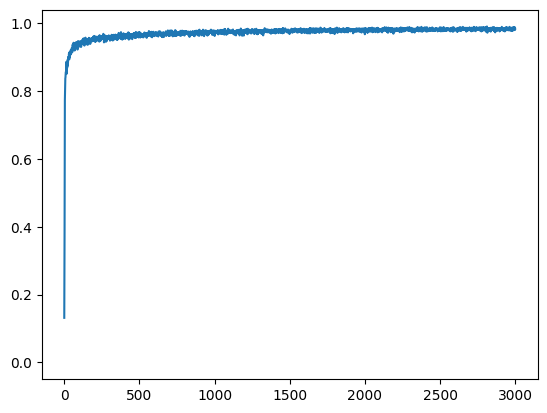

average accuracy : 0.9481781724927283
average loss : [1.97316438 1.85006218 1.73158493 ... 0.04736915 0.04430985 0.04762504]
1816/1816 [==============================] - 4s 2ms/step
0/10	 test_acc:0.9524965146899365


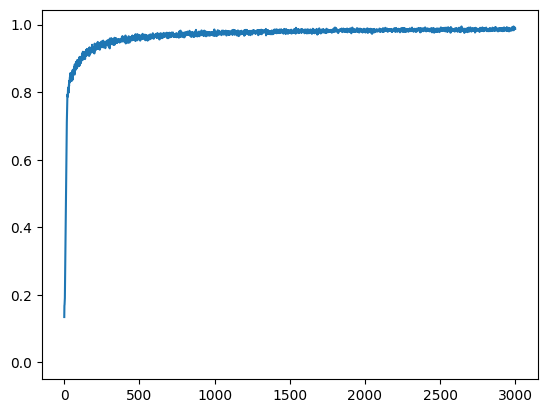

1816/1816 [==============================] - 4s 2ms/step
1/10	 test_acc:0.953184970998778


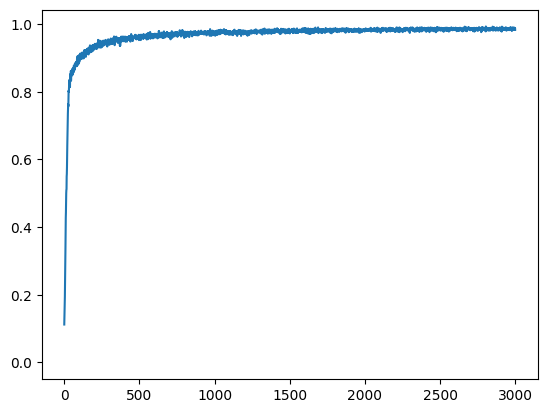

1816/1816 [==============================] - 4s 2ms/step
2/10	 test_acc:0.9524448804667733


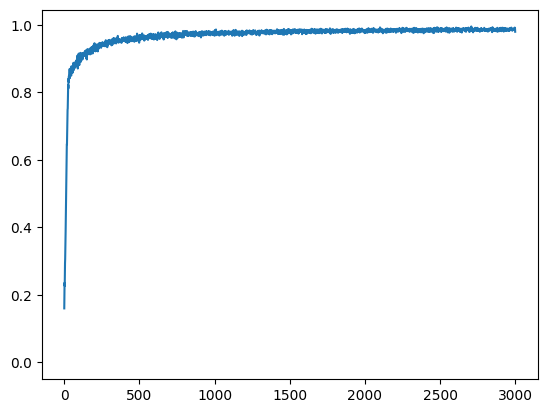

1816/1816 [==============================] - 4s 2ms/step
3/10	 test_acc:0.9528923770675204


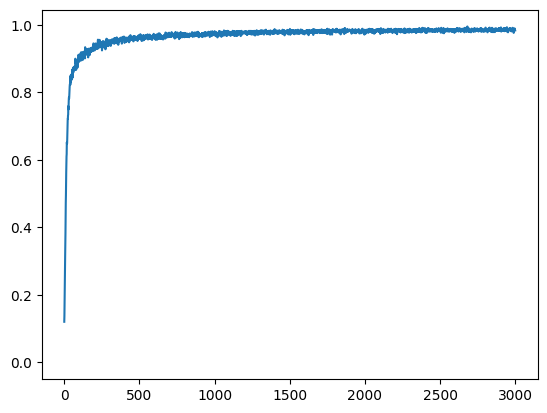

1816/1816 [==============================] - 4s 2ms/step
4/10	 test_acc:0.9515843100807215


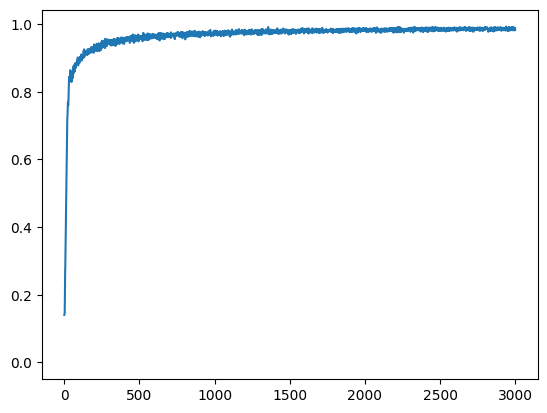

1816/1816 [==============================] - 4s 2ms/step
5/10	 test_acc:0.9503278773170858


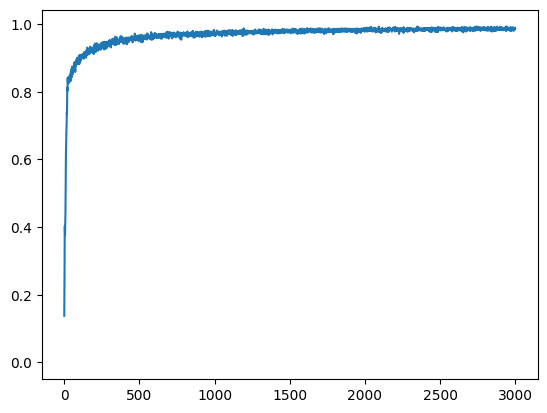

1816/1816 [==============================] - 4s 2ms/step
6/10	 test_acc:0.9549577459940448


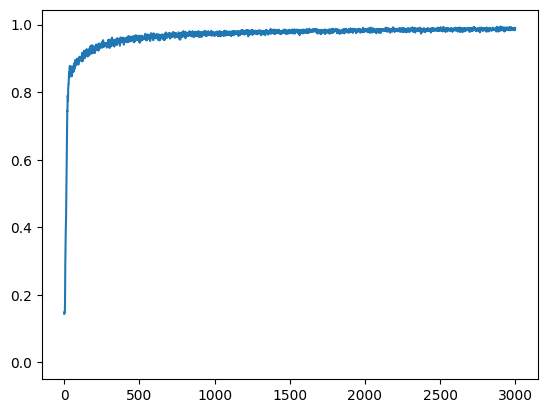

1816/1816 [==============================] - 4s 2ms/step
7/10	 test_acc:0.9424622639885716


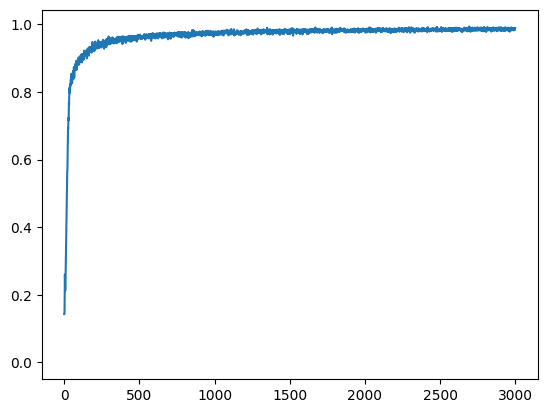

1816/1816 [==============================] - 4s 2ms/step
8/10	 test_acc:0.9525309375053785


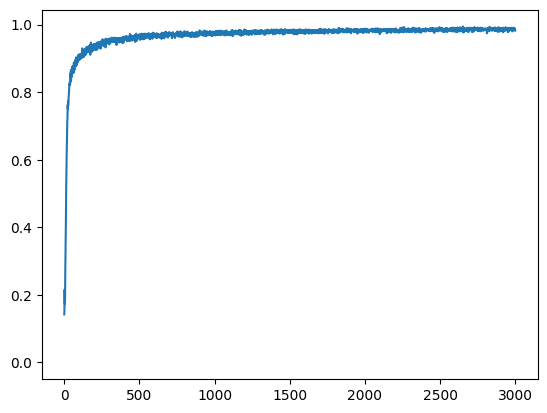

1816/1816 [==============================] - 4s 2ms/step
9/10	 test_acc:0.9541488098311561


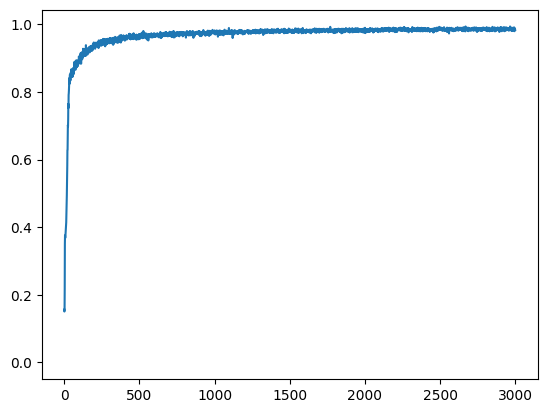

average accuracy : 0.9517030687939968
average loss : [1.9684957  1.93648494 1.91036872 ... 0.04290981 0.03954934 0.04315377]
1816/1816 [==============================] - 4s 2ms/step
0/10	 test_acc:0.95089585377188


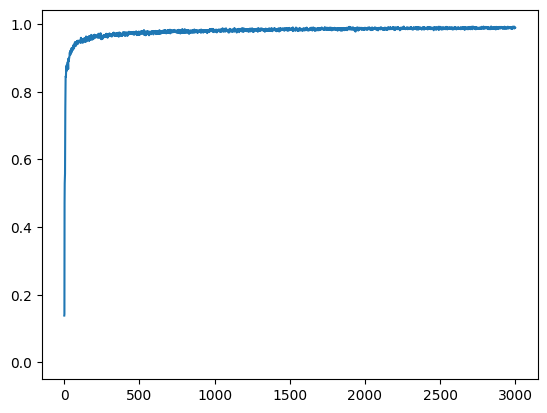

1816/1816 [==============================] - 4s 2ms/step
1/10	 test_acc:0.9524620918744944


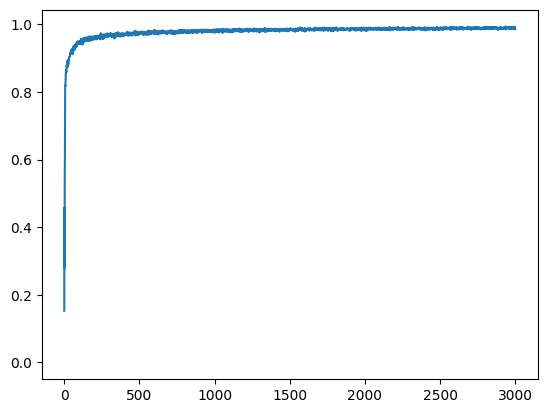

1816/1816 [==============================] - 4s 2ms/step
2/10	 test_acc:0.9543381353160875


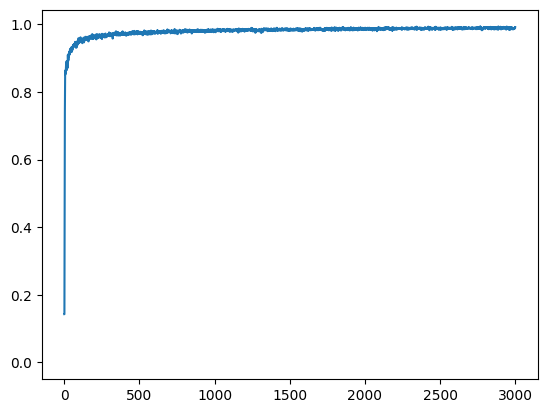

1816/1816 [==============================] - 4s 2ms/step
3/10	 test_acc:0.9545102493932979


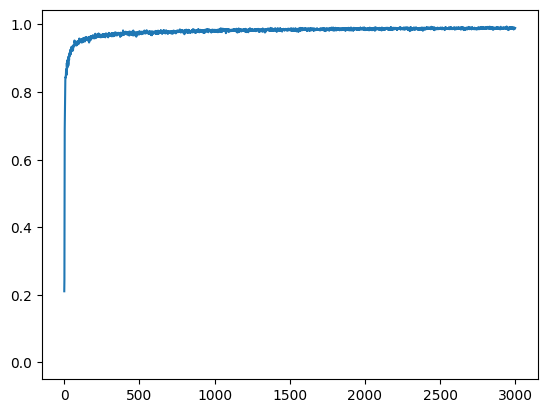

1816/1816 [==============================] - 4s 2ms/step
4/10	 test_acc:0.9541315984234351


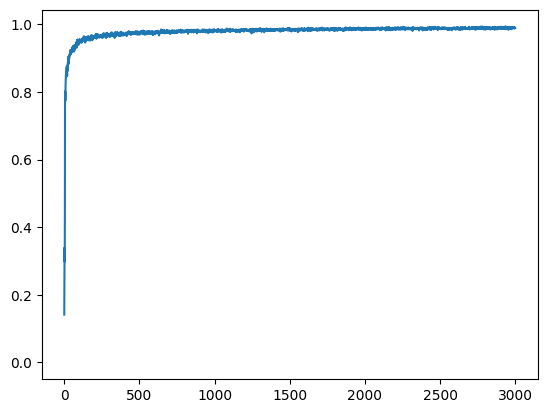

1816/1816 [==============================] - 4s 2ms/step
5/10	 test_acc:0.9567821552124748


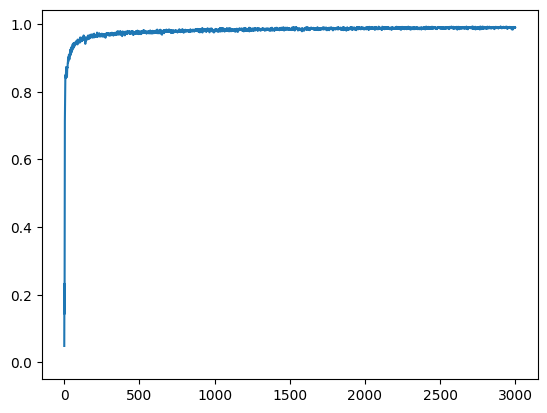

1816/1816 [==============================] - 4s 2ms/step
6/10	 test_acc:0.9575910913753636


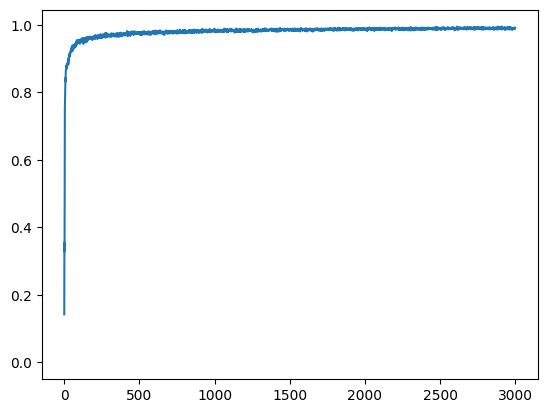

1816/1816 [==============================] - 4s 2ms/step
7/10	 test_acc:0.955921584826423


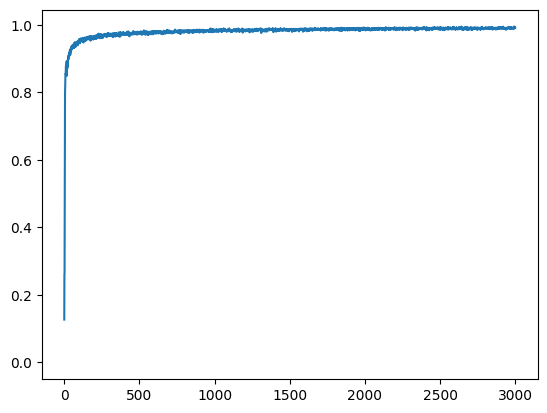

1816/1816 [==============================] - 4s 2ms/step
8/10	 test_acc:0.9551987057021394


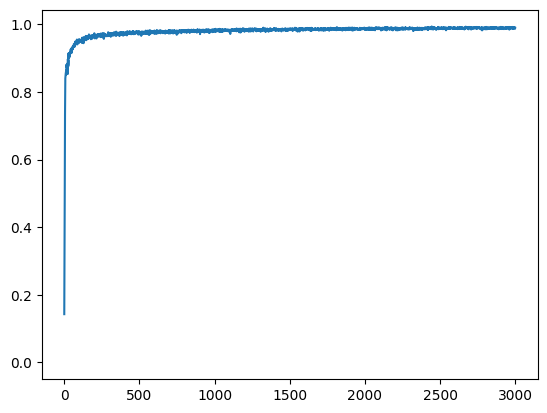

1816/1816 [==============================] - 4s 2ms/step
9/10	 test_acc:0.9551642828866973


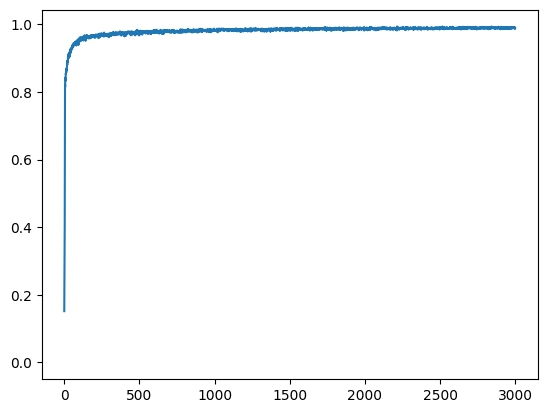

average accuracy : 0.9546995748782292
average loss : [1.97114863 1.84325851 1.71826737 ... 0.02826704 0.02865739 0.02919445]
1816/1816 [==============================] - 4s 2ms/step
0/10	 test_acc:0.9599146314177036


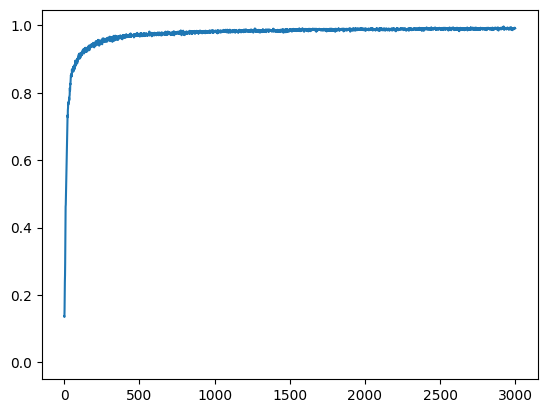

1816/1816 [==============================] - 4s 2ms/step
1/10	 test_acc:0.9587958899158362


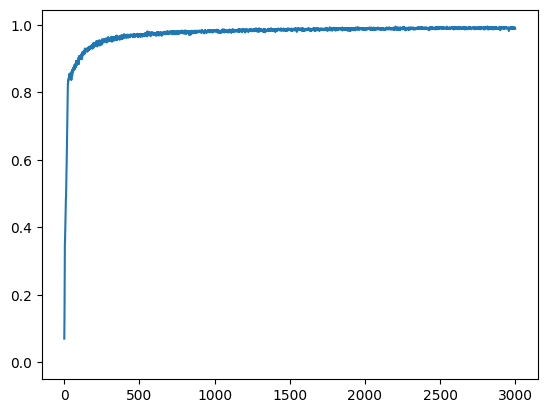

1816/1816 [==============================] - 4s 2ms/step
2/10	 test_acc:0.9565756183198224


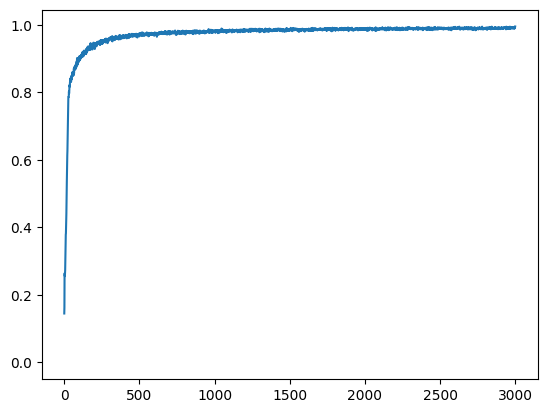

1816/1816 [==============================] - 6s 3ms/step
3/10	 test_acc:0.955525722448839


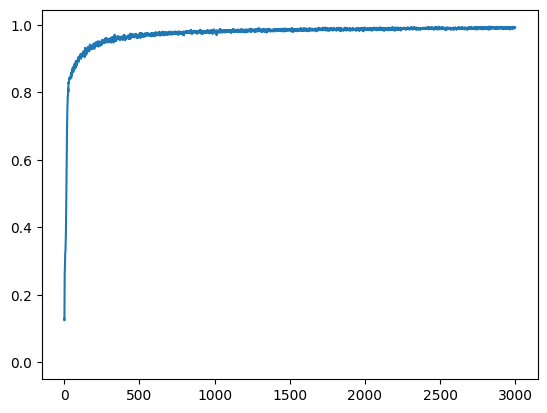

1816/1816 [==============================] - 4s 2ms/step
4/10	 test_acc:0.9550954372558131


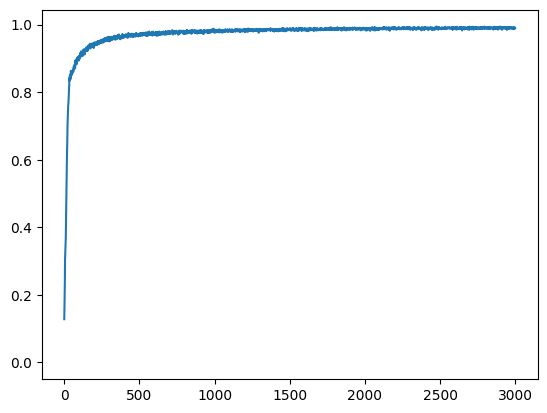

1816/1816 [==============================] - 4s 2ms/step
5/10	 test_acc:0.957298497444106


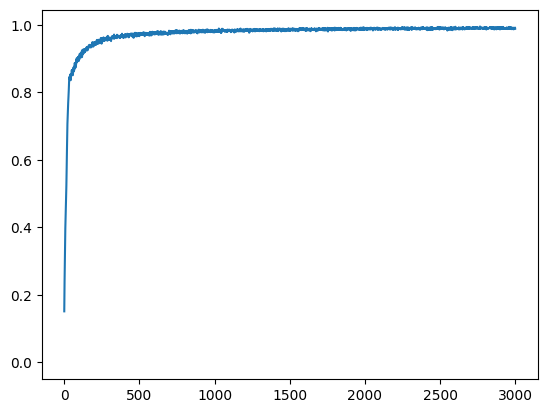

1816/1816 [==============================] - 40s 22ms/step
6/10	 test_acc:0.9572640746286639


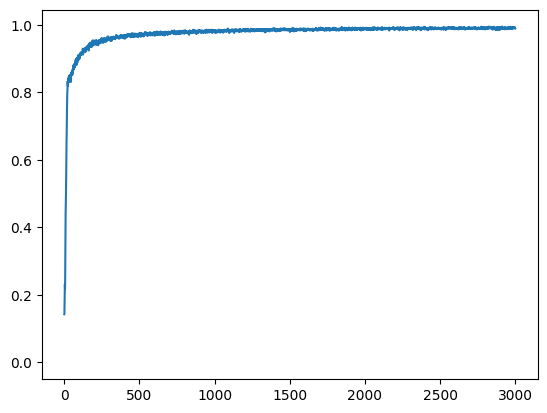

1816/1816 [==============================] - 6s 3ms/step
7/10	 test_acc:0.9551642828866973


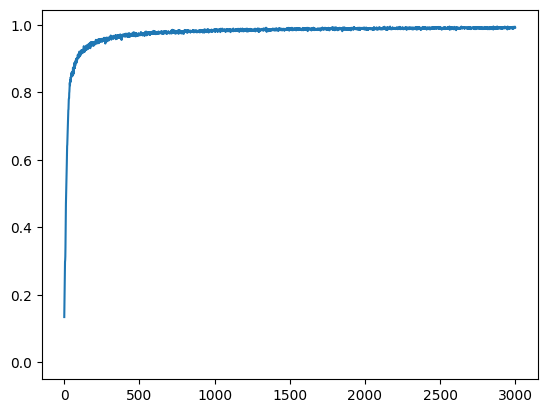

1816/1816 [==============================] - 4s 2ms/step
8/10	 test_acc:0.9597425173404933


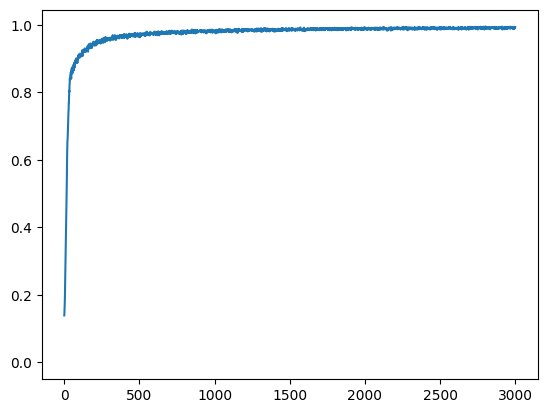

1816/1816 [==============================] - 4s 2ms/step
9/10	 test_acc:0.9581074336069947


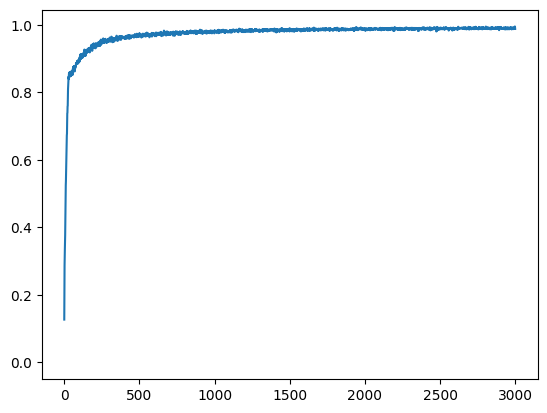

average accuracy : 0.9573484105264969
average loss : [1.96997172 1.93839293 1.91126003 ... 0.0267914  0.02650539 0.02625885]


KeyboardInterrupt: 

In [4]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.0, val_ratio=0.2)

    # 모델 불러오기 & 컴파일
    g = deep.encoder(x.shape[1:])
        
    g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.0001))

    hist = g.fit(x_train, y_train, epochs=500, batch_size = 16, validation_data=(x_val, y_val))
    
    g.trainable=False
    m = deep.final_model(x.shape[1:], g, (1296,))
    
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=1000, batch_size_per_class=16)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_val)), -1) == y_val) / y_val.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기
    
    # hyperparameters
    
    nbatch_size = [128, 256, 512, 1024]
    nlearning_rate = [0.001, 0.0001]
    nepochs  = [3000]
    
    cols = ['batch_size', 'learning_rate', 'epochs', 'test acc', 'loss']
    perform_df = pd.DataFrame(columns = cols)
    
    #grid search
    g_i = 0

    N = 10
    nClass = 2
    cm = np.zeros([N, nClass, nClass])
    
    for bs, lr, e in product(nbatch_size, nlearning_rate, nepochs):
        g_i += 1
        total = 0
        total_loss = 0
        for i in range(N):
            # Train/Test 데이터 분할
            [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.1, val_ratio=0)

            # 모델 불러오기 & 컴파일
            g = deep.encoder(x.shape[1:])
            
            g.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=Adam(learning_rate=0.001))

            # 학습
            hist = g.fit(x_train, y_train, epochs=200, batch_size = 64, verbose=0)
            g.trainable=False
            m = deep.final_model(x.shape[1:], g, g.output_shape[1:])
            
            m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
            
            # 학습시 사용하는 옵션
            train_options = exp.TrainParams(m, epochs=e, batch_size_per_class=bs)
            
            result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)
            
            total_loss = total_loss + result.train_loss
            # 테스트
            o = np.argmax(np.squeeze(result.model.predict(x_test)), -1)
            test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
            #for j in range(y_test.shape[0]):
                #cm[i, int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산

            # 결과 출력
            print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
            plt.plot(result.train_acc)
            plt.plot(result.val_acc)
            plt.show()
            total = total + test_acc_tmp
        ave = total/10
        avl = total_loss/10
        perform_df.loc[g_i] = [bs, lr, e, ave, avl]
        print(f'average accuracy : {ave}')
        print(f'average loss : {avl}')

In [6]:
perform_df = perform_df.sort_values(by='test acc')
perform_df

,batch_size,learning_rate,epochs,test acc,loss
1,128,0.001,3000,0.940075,"[1.9884642601013183, 1.8602892637252808, 1.745..."
2,256,0.001,3000,0.949404,"[1.9812856554985045, 1.8633756160736084, 1.742..."
3,512,0.001,3000,0.955811,"[1.9779759168624877, 1.8608814835548402, 1.748..."


In [35]:
# tensorflow version 확인 후 GPU 확인
import tensorflow as tf

print(f'tf.__version__: {tf.__version__}')

gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.list_physical_devices('GPU') 이 코드도 가능
for gpu in gpus:
    print(gpu)

tf.__version__: 2.10.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [15]:
g = deep.encoder(x.shape[1:])

In [17]:
g.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 31)]              0         
                                                                 
 Dense1 (Dense)              (None, 5184)              165888    
                                                                 
 BatchNormalization1 (BatchN  (None, 5184)             20736     
 ormalization)                                                   
                                                                 
 Reshape1 (Reshape)          (None, 9, 9, 64)          0         
                                                                 
 UpSampling2D1 (UpSampling2D  (None, 18, 18, 64)       0         
 )                                                               
                                                                 
 Conv2D1 (Conv2D)            (None, 18, 18, 32)        1846

In [2]:
# 텍스트 파일에서 Confusion matrix 불러오기
loaded_cm = np.loadtxt('confusion_matrix.txt', dtype=int, delimiter='\t')
print(loaded_cm)

[[204004   6031      8      0    245     26   1543]
 [ 11763 268291    693      5   1975    615    220]
 [     2    205  34009    321     78   1065      0]
 [     0      0    179   2505      0     96      0]
 [    42    248     45      0   9161     39      2]
 [     7    146    732    122     32  16259      0]
 [   257     49      0      0      4      0  19986]]


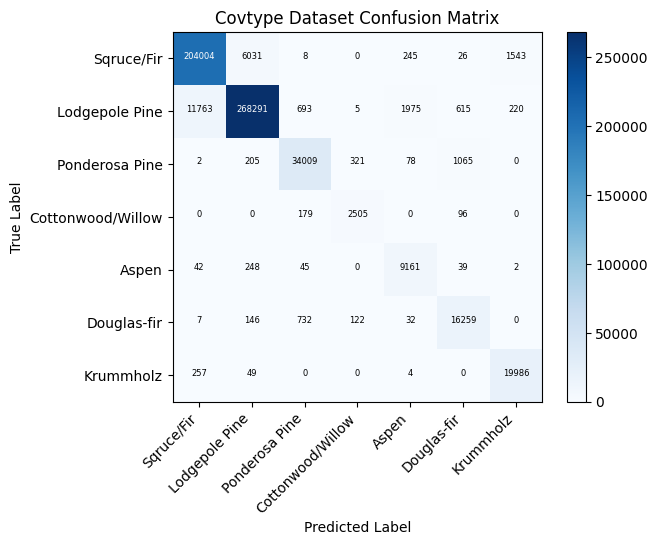

In [3]:
conf_matrix = loaded_cm

# 시각화
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Covtype Dataset Confusion Matrix')
plt.colorbar()

classes = ['Sqruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 각 셀에 숫자 표시
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(int(conf_matrix[i, j])),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black",
                 fontsize=6)  # 숫자의 글자 크기 조절

plt.show()
